## Load run from `out`

In [119]:
RESULT_DIR = "../out/2025-05-05_11-24-39_librispeech-pc-test-clean_large-v3-turbo"
# RESULT_DIR = "/home/niko/Downloads/results"

In [120]:
import os
import json

In [121]:
files = os.listdir(RESULT_DIR)
files = [f for f in files if f.endswith("final.json")]

# get ids from the first part of the filename separated by "_"
file_ids = [f.split("_")[0] for f in files]

def load_element_by_id(file_id):
    with open(os.path.join(RESULT_DIR, file_id + "_final.json"), "r") as f:
        final = json.load(f)

    with open(os.path.join(RESULT_DIR, file_id + "_final_messages.json"), "r") as f:
        final_messages = json.load(f)

    with open(os.path.join(RESULT_DIR, file_id + "_partial.json"), "r") as f:
        partials = json.load(f)
    
    return file_id, final, final_messages, partials

run = [load_element_by_id(file_id) for file_id in file_ids]

## Select an element to analyze

In [122]:
id, final, final_messages, partials = run[0]
print("ID:", id)
print("Final:", len(final))
print("Final messages:", len(final_messages))
print("Partial predictions:", len(partials))

ID: 121-123852-0000
Final: 112
Final messages: 32
Partial predictions: 98


In [123]:
threshold = 0.5

filtered_partials = []
for entry in partials:
    filtered_result = [
        word for word in entry['result']['result']
        if word['conf'] >= threshold
    ]
    # Strukturell identisch, nur mit gefilterten Wörtern
    filtered_entry = {
        **entry,
        'result': {
            **entry['result'],
            'result': filtered_result
        }
    }
    filtered_partials.append(filtered_entry)

In [124]:
filtered_word_count = sum(len(entry['result']['result']) for entry in filtered_partials)
word_count = sum(len(entry['result']['result']) for entry in partials)
print(word_count)
print(filtered_word_count)

2762
2642


In [125]:
partials = filtered_partials

In [126]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

In [127]:
window_start = 60
window_end = 80

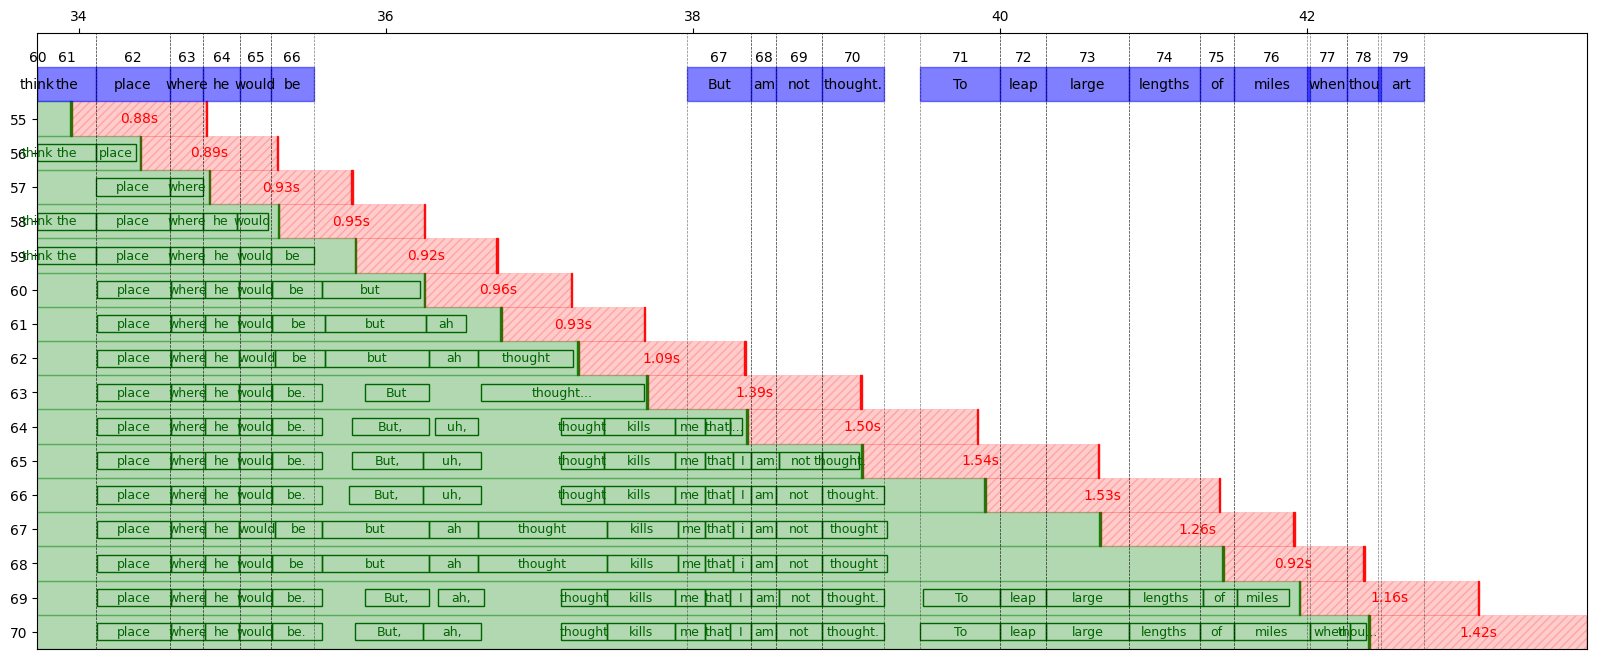

In [128]:
words = final[window_start:window_end]

window_start_t = words[0]["start"]
window_end_t = words[-1]["end"]

# Filter predictions and keep original indices
indexed_predictions = [
    (i, p) for i, p in enumerate(partials)
    if window_start_t <= p["window"][1] and (p["observation_time"] <= window_end_t or p["window"][1] <= window_end_t)
]
indexed_predictions = indexed_predictions[::-1]  # Reverse for display

# Determine max observation time for x-axis limit
max_obs_time = max(window_end_t, max(p["observation_time"] for _, p in indexed_predictions))

fig, ax = plt.subplots(figsize=(20, 8))

for row_index, (original_index, partial) in enumerate(indexed_predictions):
    win_start, win_end = partial["window"]
    obs_time = partial["observation_time"]

    # Green prediction window
    ax.add_patch(Rectangle((win_start, row_index), win_end - win_start, 1, color="green", alpha=0.3))

    # Green bar at window[1]
    marker_width = 0.01
    ax.add_patch(Rectangle((win_end - marker_width / 2, row_index), marker_width, 1, color="green", alpha=0.9))

    # Red delay box
    if obs_time > win_end:
        delay = obs_time - win_end
        ax.add_patch(Rectangle(
            (win_end, row_index), delay, 1,
            color="red", alpha=0.2, hatch='////', linewidth=0.5, fill=True
        ))
        # Delay label
        ax.text(win_end + delay / 2, row_index + 0.5, f"{delay:.2f}s", ha="center", va="center", fontsize=10, color="red")

    # Red bar at observation time
    ax.add_patch(Rectangle((obs_time - marker_width / 2, row_index), marker_width, 1, color="red", alpha=0.9))

    # Word boxes (half-height, dark green frame)
    for word in partial["result"]["result"]:
        if window_start_t <= word["start"] <= window_end_t:
            ax.add_patch(Rectangle(
                (word["start"], row_index + 0.25), word["end"] - word["start"], 0.5,
                edgecolor="darkgreen", facecolor="none", linewidth=1
            ))
            ax.text((word["start"] + word["end"]) / 2, row_index + 0.5, word["word"],
                    ha="center", va="center", fontsize=9, color="darkgreen")

# Draw top word layer (blue)
word_y = len(indexed_predictions)
for i, word in enumerate(words):
    start = word["start"]
    end = word["end"]
    ax.add_patch(Rectangle((start, word_y), end - start, 1, color="blue", alpha=0.5))
    ax.text((start + end) / 2, word_y + 0.5, word["word"], ha="center", va="center", fontsize=10)
    ax.text((start + end) / 2, word_y + 1.3, f"{window_start + i}", ha="center", va="center", fontsize=10, color="black")
    ax.axvline(start, color="black", linestyle="--", linewidth=0.5, alpha=0.5)
    ax.axvline(end, color="black", linestyle="--", linewidth=0.5, alpha=0.5)

# Axes setup
ax.set_xlim(window_start_t, max_obs_time)
ax.set_ylim(0, word_y + 2)
ax.set_yticks([i + 0.5 for i in range(len(indexed_predictions))])
ax.set_yticklabels([str(idx) for idx, _ in indexed_predictions])
ax.xaxis.tick_top()

plt.show()

In [129]:
final_messages[20]

{'result': [{'conf': 0.990723, 'start': 37.96, 'end': 38.38, 'word': 'But'},
  {'conf': 1.0, 'start': 38.38, 'end': 38.54, 'word': 'am'},
  {'conf': 0.999512, 'start': 38.54, 'end': 38.84, 'word': 'not'},
  {'conf': 0.999512, 'start': 38.84, 'end': 39.24, 'word': 'thought.'}],
 'reason': 'sentence end',
 'observation_time': 41.42852590046823}

In [130]:
partials[32]

{'result': {'result': [{'conf': 0.805176,
    'start': 6.95,
    'end': 7.19,
    'word': 'thy'},
   {'conf': 0.936035, 'start': 7.19, 'end': 7.65, 'word': 'heart'},
   {'conf': 0.783203, 'start': 7.65, 'end': 9.11, 'word': 'thy'},
   {'conf': 0.996094, 'start': 9.11, 'end': 9.63, 'word': 'beauty'},
   {'conf': 0.993652, 'start': 9.63, 'end': 10.45, 'word': 'and'},
   {'conf': 0.99707, 'start': 10.45, 'end': 10.73, 'word': 'thy'},
   {'conf': 0.978516, 'start': 10.73, 'end': 11.33, 'word': 'years'},
   {'conf': 0.914062, 'start': 11.33, 'end': 11.71, 'word': 'full'},
   {'conf': 0.993652, 'start': 11.71, 'end': 12.11, 'word': 'well'},
   {'conf': 0.996826, 'start': 12.11, 'end': 12.75, 'word': 'befits'},
   {'conf': 0.990723,
    'start': 12.75,
    'end': 13.969999999999999,
    'word': 'for'},
   {'conf': 0.998535,
    'start': 13.969999999999999,
    'end': 14.41,
    'word': 'still'},
   {'conf': 0.998047, 'start': 14.41, 'end': 15.21, 'word': 'temptation'},
   {'conf': 0.996094, '

In [131]:
for i, m in enumerate(final_messages):
    print(i, f"{m['observation_time']:6.2f} -", m["reason"])

0   5.55 - sentence end
1   9.67 - threshold reached
2  12.45 - threshold reached
3  14.42 - threshold reached
4  18.92 - threshold reached
5  20.01 - threshold reached
6  21.53 - threshold reached
7  22.43 - threshold reached
8  23.49 - threshold reached
9  24.37 - threshold reached
10  26.56 - threshold reached
11  27.49 - threshold reached
12  28.40 - threshold reached
13  29.31 - threshold reached
14  30.90 - threshold reached
15  32.98 - threshold reached
16  33.91 - threshold reached
17  34.83 - threshold reached
18  36.72 - threshold reached
19  39.09 - threshold reached
20  41.43 - sentence end
21  42.37 - threshold reached
22  44.54 - threshold reached
23  45.52 - threshold reached
24  46.47 - threshold reached
25  47.79 - threshold reached
26  48.95 - threshold reached
27  54.53 - threshold reached
28  58.83 - threshold reached
29  59.76 - threshold reached
30  61.20 - threshold reached
31  61.20 - end stream


## Build dataframe

In [132]:
import pandas as pd
import numpy as np

In [133]:
df = pd.DataFrame(partials)
df["window_start"] = df["window"].apply(lambda x: x[0])
df["window_end"] = df["window"].apply(lambda x: x[1])
df["window_duration"] = df["window_end"] - df["window_start"]
df["min_word_start"] = df["result"].apply(lambda x: min([w["start"] for w in x["result"]]))
df["max_word_end"] = df["result"].apply(lambda x: max([w["end"] for w in x["result"]]))
df["observation_delay"] = df["observation_time"] - df["window_end"]
# df["word_count"] = df["result"].apply(lambda x: len(x["result"]))

df.drop(["result", "window"], axis=1, inplace=True)
df[18:25]

,observation_time,window_start,window_end,window_duration,min_word_start,max_word_end,observation_delay
18,16.058017,0.00,15.15,15.15,0.08,12.70,0.908017
19,16.581227,0.00,15.65,15.65,0.08,15.24,0.931227
20,17.222770,0.00,16.10,16.10,0.80,15.24,1.122770
21,17.929378,0.00,16.60,16.60,0.08,16.58,1.329378
22,18.461347,0.00,17.25,17.25,0.80,17.14,1.211347
23,18.922936,0.00,17.95,17.95,0.08,14.42,0.972936
24,19.543665,3.45,18.50,15.05,4.27,17.27,1.043665


## Timing Metrics

In [137]:
def word_first_correct_response(final_index, acceptance_time=1.0):
    '''
    Given the index of a final word, return the first partial response that contains the word
    and the time it was produced.
    '''
    target_word = final[final_index]
    word_start = target_word["start"]
    word_end = target_word["end"]
    word = target_word["word"]
    for i, partial in enumerate(partials):
        if partial["observation_time"] < word_start:
            continue
        for w in partial["result"]["result"]:
            if w["word"] == word and w["start"] >= word_start - acceptance_time and w["start"] <= word_end + acceptance_time:
                return {
                    "timestep": i,
                    "observation_time": partial["observation_time"],
                    "latency": partial["observation_time"] - word_start,
                }

def word_first_final_response(final_index, acceptance_time=1.0):
    '''
    Given the index of a final word, return the partial response after which the word does not change anymore and thus becomes final.
    '''
    target_word = final[final_index]
    word_start = target_word["start"]
    word_end = target_word["end"]
    word = target_word["word"]
    last_found_at_index = None
    candidate = None
    for i, partial in enumerate(partials):
        if partial["observation_time"] < word_start:
            continue
        if (len(partial["result"]["result"])
            and partial["result"]["result"][0]["start"] > word_end + acceptance_time
        ):
            return candidate
        for w in partial["result"]["result"]:
            if w["word"] == word and w["start"] >= word_start - acceptance_time and w["end"] <= word_end + acceptance_time:
                last_found_at_index = i
                if (
                    candidate is None
                    or last_found_at_index < i-1 
                ):
                    candidate = {
                        "timestep": i,
                        "observation_time": partial["observation_time"],
                        "latency": partial["observation_time"] - word_start,
                    }
    return candidate
        
            

wfc = [word_first_correct_response(i, acceptance_time=1.0) for i in range(len(final))]
print([i for i in range(len(final)) if wfc[i] is None])
wfc_latency = np.array([r["latency"] for r in wfc if r is not None])

ffc = [word_first_final_response(i) for i in range(len(final))]
print([i for i in range(len(final)) if ffc[i] is None])
ffc_latency = np.array([r["latency"] for r in ffc if r is not None])

[67, 110, 111]
[67, 110, 111]


In [138]:
ffc_latency.mean().item()

1.893874312917437

In [140]:
wfc_latency.mean().item()

1.893874312917437